In [3]:
import os
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.ticker as mticker
warnings.filterwarnings('ignore')
pplt.rc.update({'toplabel.weight':'normal','leftlabel.weight':'normal','fontsize':14,'figure.dpi':100})

In [4]:
with open('../scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'test'

In [5]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5', engine='h5netcdf') as ds:
    lev = ds['lev'].load()

results = []
for model in MODELS:
    name,desc = model['name'],model['description']
    if 'kernel' not in name:
        continue
    filepath = os.path.join(WEIGHTSDIR,f'{name}_{SPLIT}_weights.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath,engine='h5netcdf') as ds:
        if ('k1' in ds) and ('k2' in ds):
            k1,k2 = ds['k1'].load(),ds['k2'].load()
            k1mean,k2mean = k1.mean('seed'),k2.mean('seed')
            k1std,k2std   = k1.std('seed'),k2.std('seed')
            results.append((name,desc,'mixture',k1mean,k1std,k2mean,k2std))
        else:
            k     = ds['k'].load()
            kmean = k.mean('seed')
            kstd  = k.std('seed')
            results.append((name,desc,'single',kmean,kstd))

print(f'Found {len(results)} kernel models with saved weights!')

Found 6 kernel models with saved weights!


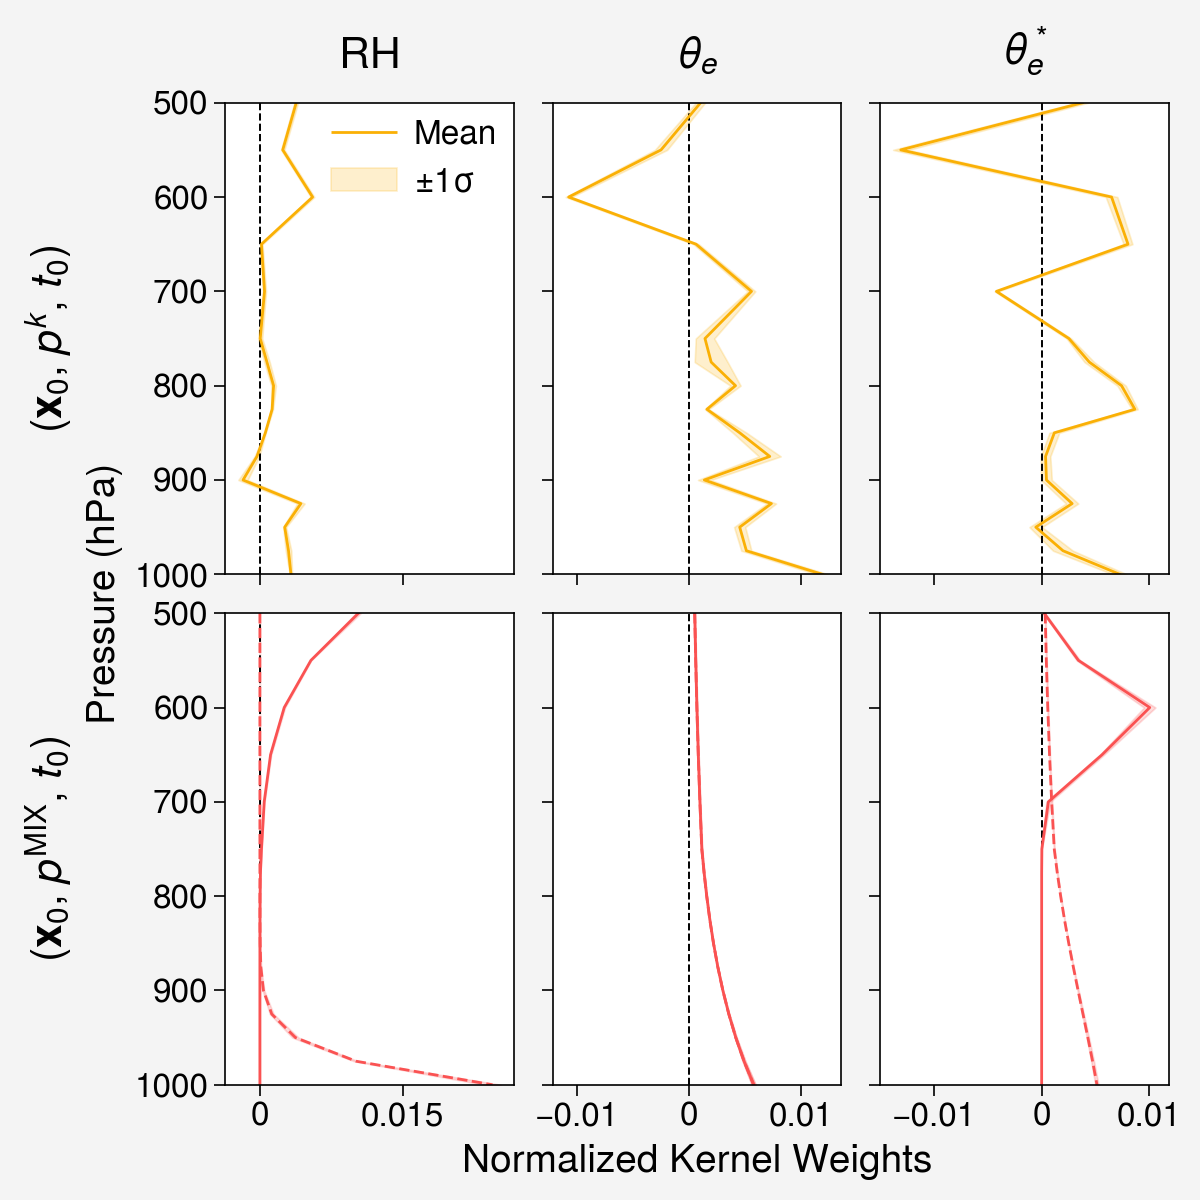

In [6]:
keys = ('nonparametric', 'mixparametric')
rows = [next(r for r in results if k in r[0]) for k in keys]
rowlabels = [r[1] for r in rows]
collabels = ['RH',r'$\mathit{\theta_e}$',r'$\mathit{\theta_e^*}$']

fig,axs = pplt.subplots(nrows=len(rowlabels),ncols=len(collabels),width=6,height=6,wspace=1,hspace=1,sharex='limits',sharey=True)
axs.format(rowlabels=rowlabels,collabels=collabels,grid=False,
           xlabel='Normalized Kernel Weights',xticklabelsize=12,
           ylabel='Pressure (hPa)',yticklabelsize=12,yminorticks='none')
for row,(name,desc,kind,*data) in enumerate(rows):
    color = 'yellow6' if ('nonparametric' in name) else 'red6'
    for col in range(len(collabels)):
        ax = axs[row,col]
        ax.axvline(0,color='k',linewidth=0.7,linestyle='--')
        if kind=='mixture':
            mean1,std1 = data[0].isel(field=col),data[1].isel(field=col)
            mean2,std2 = data[2].isel(field=col),data[3].isel(field=col)
            ax.plot(mean1,lev,color=color,linewidth=1)
            ax.plot(mean2,lev,color=color,linewidth=1,linestyle='--')
            ax.fill_betweenx(lev,mean1-std1,mean1+std1,color=color,alpha=0.2)
            ax.fill_betweenx(lev,mean2-std2,mean2+std2,color=color,alpha=0.2)
        else:
            mean,std = data[0].isel(field=col),data[1].isel(field=col)
            ax.plot(mean,lev,color=color,linewidth=1,label='Mean')
            ax.fill_betweenx(lev,mean-std,mean+std,color=color,alpha=0.2,label=r'$\pm 1\sigma$')
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=3,prune='both'))
        ax.xaxis.set_minor_locator(mticker.NullLocator())
axs.format(xreverse=False,yreverse=True)
axs[:-1,:].tick_params(axis='x',labelbottom=False)
axs[0,0].legend(loc='ur',ncols=1,frame=False,prop={'size':12})
pplt.show()
fig.save('../figs/fig_3.png')

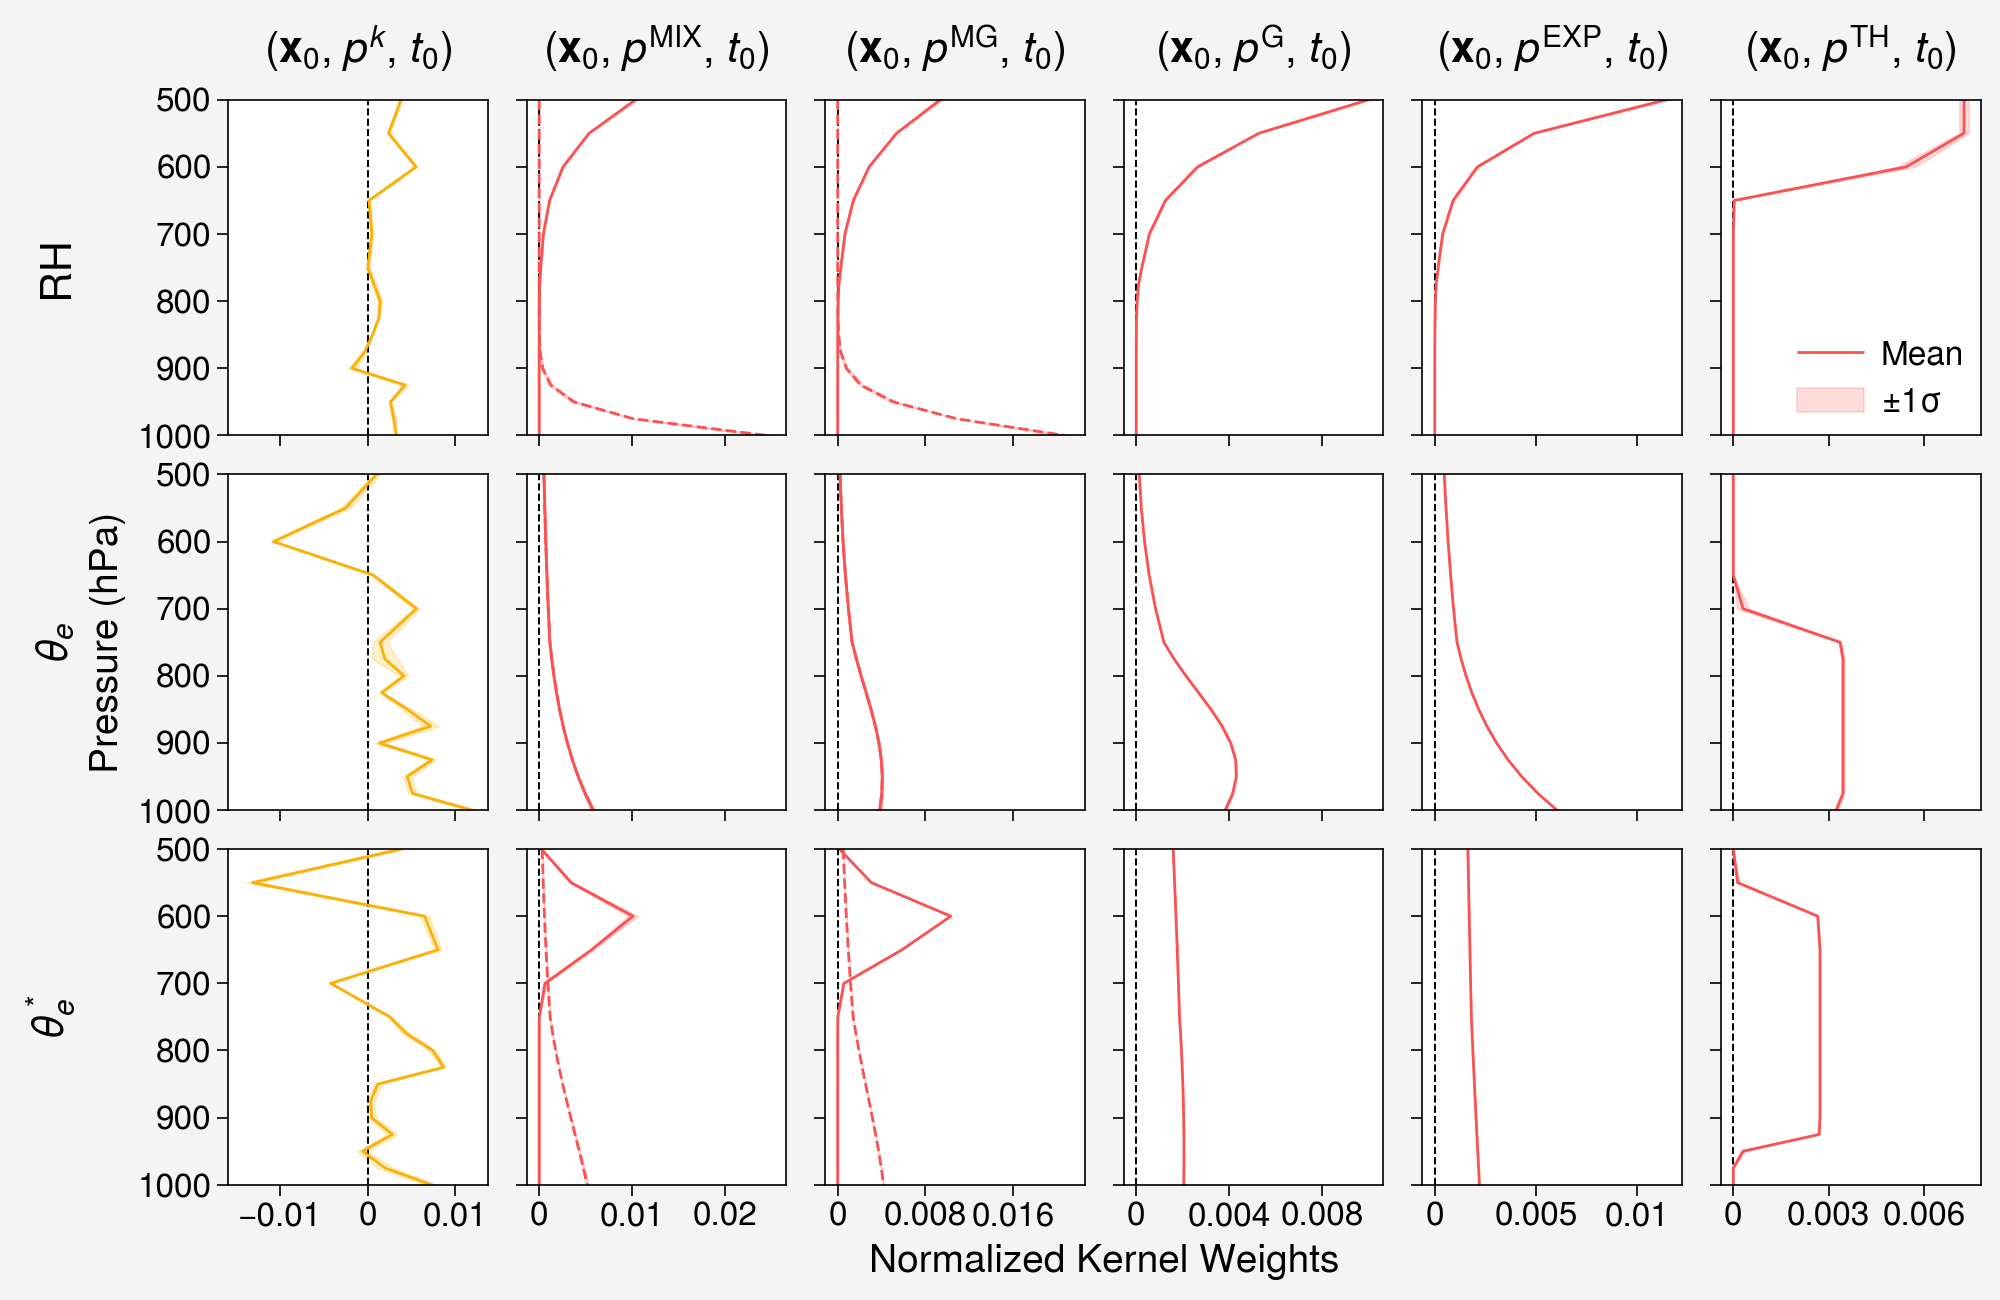

In [7]:
order = ('nonparametric','mixparametric','mixgaussian','gaussian','exponential','tophat')
cols  = sorted(results,key=lambda r:next((i for i,k in enumerate(order) if k in r[0]),len(order)))
collabels = [r[1] for r in cols]
rowlabels = ['RH',r'$\mathit{\theta_e}$',r'$\mathit{\theta_e^*}$']

fig,axs = pplt.subplots(nrows=len(rowlabels),ncols=len(collabels),width=10,height=6.5,wspace=1,hspace=1,sharex='limits',sharey=True)
axs.format(rowlabels=rowlabels,collabels=collabels,grid=False,
           xlabel='Normalized Kernel Weights',xticklabelsize=12,
           ylabel='Pressure (hPa)',yticklabelsize=12,yminorticks='none')
for col,(name,desc,kind,*data) in enumerate(cols):
    color = 'yellow6' if ('nonparametric' in name) else 'red6'
    for row in range(len(rowlabels)):
        ax = axs[row,col]
        ax.axvline(0,color='k',linewidth=0.7,linestyle='--')
        if kind=='mixture':
            mean1,std1 = data[0].isel(field=row),data[1].isel(field=row)
            mean2,std2 = data[2].isel(field=row),data[3].isel(field=row)
            ax.plot(mean1,lev,color=color,linewidth=1)
            ax.plot(mean2,lev,color=color,linewidth=1,linestyle='--')
            ax.fill_betweenx(lev,mean1-std1,mean1+std1,color=color,alpha=0.2)
            ax.fill_betweenx(lev,mean2-std2,mean2+std2,color=color,alpha=0.2)
        else:
            mean,std = data[0].isel(field=row),data[1].isel(field=row)
            ax.plot(mean,lev,color=color,linewidth=1,label='Mean')
            ax.fill_betweenx(lev,mean-std,mean+std,color=color,alpha=0.2,label=r'$\pm 1\sigma$')
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=3,prune='both'))
        ax.xaxis.set_minor_locator(mticker.NullLocator())
axs.format(xreverse=False,yreverse=True)
axs[:-1,:].tick_params(axis='x',labelbottom=False)
for col in range(axs.shape[1]):
    ax = axs[-1,col]         
    xmin,xmax = ax.get_xlim()
    pad = 0.05*max(abs(xmin),abs(xmax),1e-12)
    ax.set_xlim(xmin-pad,xmax)
axs[0,5].legend(loc='lr',ncols=1,frame=False,prop={'size':12})
pplt.show()
fig.save('../figs/fig_A1.png')